## Customising the environment class - Timing of actions and inputs

Beside the action and observation spaces (see example 3), the timing between fmu timesteps, the interval between two agent actions and the resolution of external data is something that you might want to customize.

Like in example 3, the energy managenment of a DC microgrid is chosen. The microgrid consist of a PV array, a battery storage, a load and a grid connection. The main idea is to optimise the use of the battery storage to minimise the energy consumption from the main grid and maximise the use of the PV energy. As basis of this example, the same customised environment with the reduced action and observation spaces is used. So the environment definition is imported from an external file, for details see example 3. 

The fmu has a base time step of 0.01 seconds which is very short but necessary to simulate all dynamic effects. It isn't realistic that the agent will take an action every 10 ms, so this time shall be changed to an action every ten seconds. Also, the simulation time is changed to fifteen minutes. This is updated in the config file for this example (04-config.cfg).

```
[FMU]
FMU_path = 03-MicrogridFMU.fmu
stop_time = 900.0
dt = 0.01
action_interval = 10.0
```

All data handling and simulations necessary between two agent actions are done by the StableRLS package. Only the timing of external inputs needs to handled manually. For this, the pre-defined function *FMU_external_input* is modified. Every second, the load power is updated from a load profile which is imported during the *reset_*. Every 60 seconds the PV inputs (irradiance/module temperature) are updated from the imported data. In between this updates the normal cycle of fmu and agent steps is done.

In [25]:
# import packages as in the other examples
import stablerls.configreader as cfg_reader
import stablerls.gymFMU as gymFMU
import numpy as np
import pandas as pd
import gymnasium as gym
import logging
import random
import datetime
import os

logger = logging.getLogger(__name__)

class GridEnv(gymFMU.StableRLS):
    def set_action_space(self):
        """Setter function for the action space of the agent.
        
        Returns
        -------
        space : gymnasium.space
            Returns the action space defined by specified FMU inputs
        """
        return gym.spaces.MultiDiscrete([11, 11])
    
    def set_observation_space(self):
        """Setter function for the observation space of the agent.

        Returns
        -------
        space : gymnasium.space
            Returns the observation space defined by specified FMU outputs
        """
        high = np.arange(8).astype(np.float32)
        high[:] = 1
        low = high * -1
        return gym.spaces.Box(low, high)
    
    def assignAction(self, action):
        """Changed assignment of actions to the FMU because only certain inputs
        are used for the agent actions.

        Parameters
        ----------
        action : list
            An action provided by the agent to update the environment state.
        """
        # assign actions to inputs
        # check if actions are within action space
        if not self.action_space.contains(action):
            logger.info(f"The actions are not within the action space. Action: {action}. Time: {self.time}")

        # convert discrete actions into steps of voltage references
        vStepGrid = (action[0] - 5) * 0.04    
        vStepBat = (action[1] - 5) * 0.04

        # add them to actual references to get new setpoints
        vRefGrid = self.fmu.fmu.getReal([self.fmu.input[3].valueReference])[0] + vStepGrid  
        vRefBat = self.fmu.fmu.getReal([self.fmu.input[5].valueReference])[0] + vStepBat

        # assign actions to the FMU inputs - take care of right indices!
        self.fmu.fmu.setReal([self.fmu.input[3].valueReference], [vRefGrid])
        self.fmu.fmu.setReal([self.fmu.input[5].valueReference], [vRefBat])

    def obs_processing(self, raw_obs):
        """Customised action processing: Only specific outputs are evaluated. Additionally,
        they are normalised to +-1.

        Parameters
        ----------
        raw_obs : ObsType
            The raw observation defined by all FMU outputs.
        Returns
        -------
        observation : ObsType
            The processed observation for the agent.
        """

        nDec = 2
        observation = np.array([  round((raw_obs[0] - self.nominal_voltage) / (0.1*self.nominal_voltage), 2),   # PV.V
                                  round((raw_obs[3] - self.nominal_voltage) / (0.1*self.nominal_voltage), 2),   # Grid.V                     
                                  round((raw_obs[6] - self.nominal_voltage) / (0.1*self.nominal_voltage), 2),   # Load.V
                                  round((raw_obs[13] - self.nominal_voltage) / (0.1*self.nominal_voltage), 2),  # Bat.V  
                                  round(raw_obs[2] / self.nominal_current, 2),                                  # PV.I
                                  round(raw_obs[5] / self.nominal_current, 2),                                  # Grid.I
                                  round(raw_obs[12] / self.nominal_current, 2),                                 # Bat.Inet
                                  round(raw_obs[11], nDec),                                                     # Bat.SOC
                               ]).astype(np.float32)

        return observation

    def reset_(self, seed=None):
        """Since zeros make no sense for the voltage references, the input reset is
        changed. Also, the initial SOC is chosen randomly between limits.

        Parameters
        ----------
        seed : int, optional
            - None -
        """
        # set voltage references to nominal voltage
        self.fmu.fmu.setReal([self.fmu.input[3].valueReference], [self.nominal_voltage])
        self.fmu.fmu.setReal([self.fmu.input[5].valueReference], [self.nominal_voltage])

        # set initial SOC, randomly chosen
        rand = random.random()
        if rand < 0.15:
            self.soc_init = 0.15
        elif rand > 0.85:
            self.soc_init = 0.85
        else:
            self.soc_init = rand 
        self.fmu.fmu.setReal([self.fmu.input[4].valueReference], [self.soc_init])

        # for the other inputs external data is imported
        load = pd.read_pickle(os.path.join("04-loadProfile.pkl"))
        pv = pd.read_pickle(os.path.join("04-inputPV.pkl"))

        # from this profiles a random intervall is selected
        delta = pv.loc[len(pv)-1, "Time"] - pv.loc[0, "Time"]
        delta -= datetime.timedelta(seconds=self.stop_time)
        deltaMins = delta.days*1440 + delta.seconds/60
        randOffset = random.randint(0, deltaMins)*60
        startDate = pv.loc[0, "Time"] + datetime.timedelta(seconds=randOffset)
        stopDate = startDate + datetime.timedelta(seconds=self.stop_time)

        # input data for PV panel
        self.inptPV = pv.loc[(pv["Time"] >= startDate) & (pv["Time"] <= stopDate),:]
        
        # load profile data
        self.inptLoad = load.loc[(load["Time"] >= startDate) & (load["Time"] <= stopDate),:]

        # get the first observation as specified by gymnaisum
        self._next_observation(steps=1)
        return self.obs_processing(self.outputs[self.step_count, :])

    def FMU_external_input(self):
        """This function is called before each FMU step. Here external FMU
        inputs independent of the agent action are set. In this case, this includes
        weather data and the load power.

        Use the code below to access the FMU inputs.
        self.fmu.fmu.setReal([self.fmu.input[0].valueReference], [value])
        """
        # update PV input every minute
        t_in = round(self.time,3)
        if (t_in % 60 == 0):
            # Irradiance
            self.fmu.fmu.setReal([self.fmu.input[1].valueReference], [self.inptPV.iloc[int(self.time/60),0]])

            # ModuleTemperature
            self.fmu.fmu.setReal([self.fmu.input[0].valueReference], [self.inptPV.iloc[int(self.time/60),1]])

        # update LoadPower every second
        if t_in.is_integer():
            self.fmu.fmu.setReal([self.fmu.input[2].valueReference], [self.inptLoad.iloc[int(self.time),0]])

With this modified environment class ten minutes are simulated.

In [26]:
# read config-file
config = cfg_reader.configreader('04-config.cfg')

# create new env object and reset it before simulating
microgrid = GridEnv(config)
obs = microgrid.reset()

# for this example, the actions are kept constant at the reference value of 48 V
action = np.array([5,5])

terminated = False
truncated = False
while not (terminated or truncated):
    observation, reward, terminated, truncated, info  = microgrid.step(action)
    print(f'Action: {action}\nObservation: {observation}\n')

microgrid.close()

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.02 -0.03 -0.06 -0.03  0.12  0.02  0.03  0.26]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.26]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.25]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.25]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.25]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.25]

Action: [5 5]
Observation: [-0.08 -0.08 -0.13 -0.09  0.12  0.07  0.07  0.25]

Action: [5 5]
Observation: [-0.13 -0.11 -0.17 -0.12  0.06  0.09 

To show the simulation results, they are plotted.

C:\Users\cfn2169\AppData\Local\Temp\ipykernel_18504\2061761359.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figIrr.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_18504\2061761359.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figLoad.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_18504\2061761359.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figAct.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_18504\2061761359.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figOutV.show()
C:\Users\cfn2169\AppData\Local\Temp\ipykernel_18504\2061761359.py:48: UserWarning: Matplot

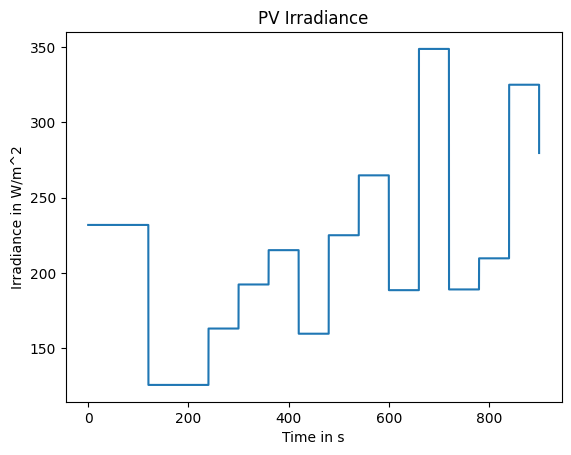

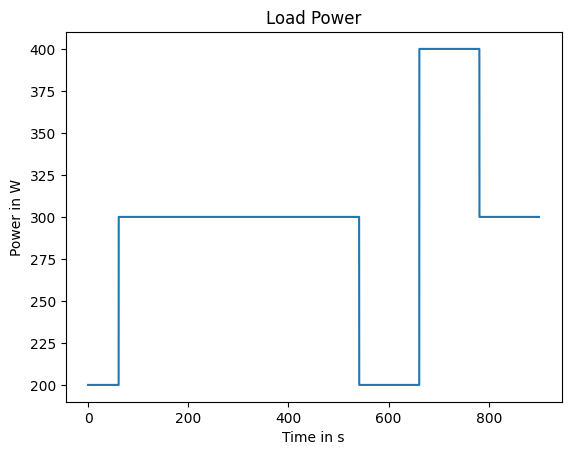

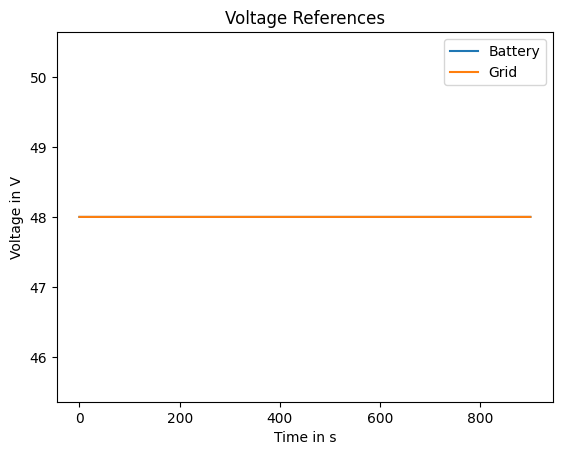

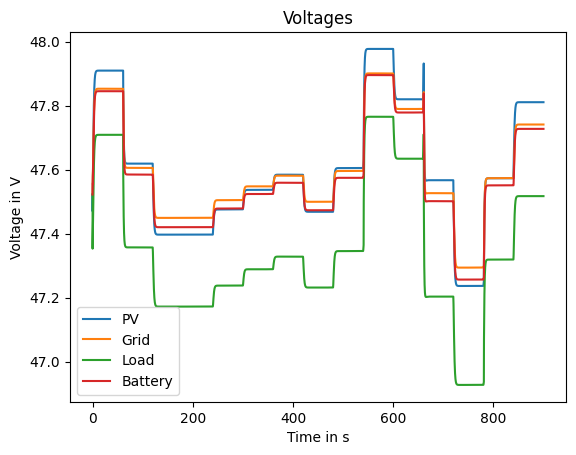

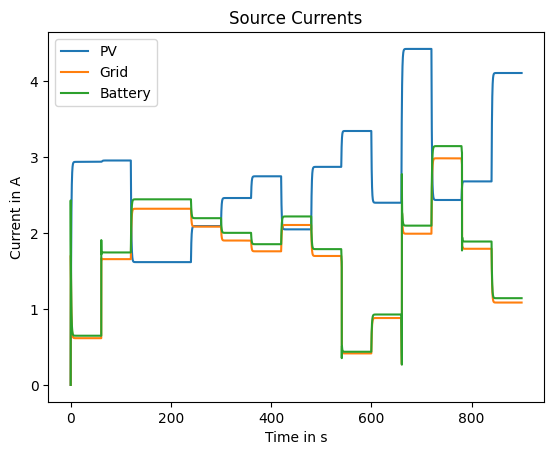

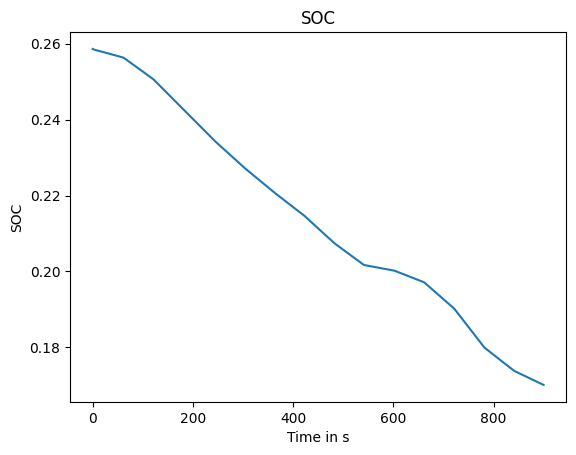

In [27]:
import matplotlib
import matplotlib.pyplot as plt

# plot external inputs
figIrr, axsIrr = plt.subplots(1,1)
axsIrr.plot(microgrid.times, microgrid.inputs[:,1])
axsIrr.set_title("PV Irradiance")
axsIrr.set_xlabel("Time in s")
axsIrr.set_ylabel("Irradiance in W/m^2")
figIrr.canvas.draw()
figIrr.show()

figLoad, axsLoad= plt.subplots(1,1)
axsLoad.plot(microgrid.times, microgrid.inputs[:,2])
axsLoad.set_title("Load Power")
axsLoad.set_xlabel("Time in s")
axsLoad.set_ylabel("Power in W")
figLoad.canvas.draw()
figLoad.show()

# plot agent actions
figAct, axsAct = plt.subplots(1,1)
line1, line2, = axsAct.plot(microgrid.times, microgrid.inputs[:,3], microgrid.times, microgrid.inputs[:,5])
axsAct.legend([line1, line2],["Battery", "Grid"])
axsAct.set_title("Voltage References")
axsAct.set_xlabel("Time in s")
axsAct.set_ylabel("Voltage in V")
figAct.canvas.draw()
figAct.show()
        
# plot outputs (voltages/source currents)
figOutV, axsOutV = plt.subplots(1,1)
line3, line4, line5, line6, = axsOutV.plot(microgrid.times,microgrid.outputs[:,0],microgrid.times,microgrid.outputs[:,3],microgrid.times,microgrid.outputs[:,6],microgrid.times,microgrid.outputs[:,13])
axsOutV.legend([line3, line4, line5, line6],["PV", "Grid","Load","Battery"])
axsOutV.set_title("Voltages")
axsOutV.set_xlabel("Time in s")
axsOutV.set_ylabel("Voltage in V")
figOutV.canvas.draw()
figOutV.show()

figOutI, axsOutI = plt.subplots(1,1)
line7, line8, line9, = axsOutI.plot(microgrid.times,microgrid.outputs[:,2],microgrid.times,microgrid.outputs[:,5],microgrid.times,microgrid.outputs[:,12])
axsOutI.legend([line7, line8, line9],["PV", "Grid", "Battery"])
axsOutI.set_title("Source Currents")
axsOutI.set_xlabel("Time in s")
axsOutI.set_ylabel("Current in A")
figOutI.canvas.draw()
figOutI.show()
        
# plot SOC
figBat, axsBat = plt.subplots(1,1)
axsBat.plot(microgrid.times,microgrid.outputs[:,11])
axsBat.set_xlabel("Time in s")
axsBat.set_ylabel("SOC")
axsBat.set_title("SOC")
figBat.canvas.draw()
figBat.show()